# Why use Visual Transformers instead of CNN?

CNN have drawbacks

- inductive bias (anything which makes the algorithm learn one pattern instead of another pattern), e.g. locality: CNN model uses convolutions to build feature maps to gain high-level representation of image to classify it correctly, but sometimes we don't need to do a lot of local convolution operations for that (look at the picture of tiger, to find the tiger we just need to look at the whole picture and find color incosistency between plants and tiger fur);

- translation equivariance (CNN processes different parts of image with the same algorithm and, as a result, looks for some image details (e.g. wheels, eyes, faces) in image places where there is no place for them (sky, sea, forest, etc.)).

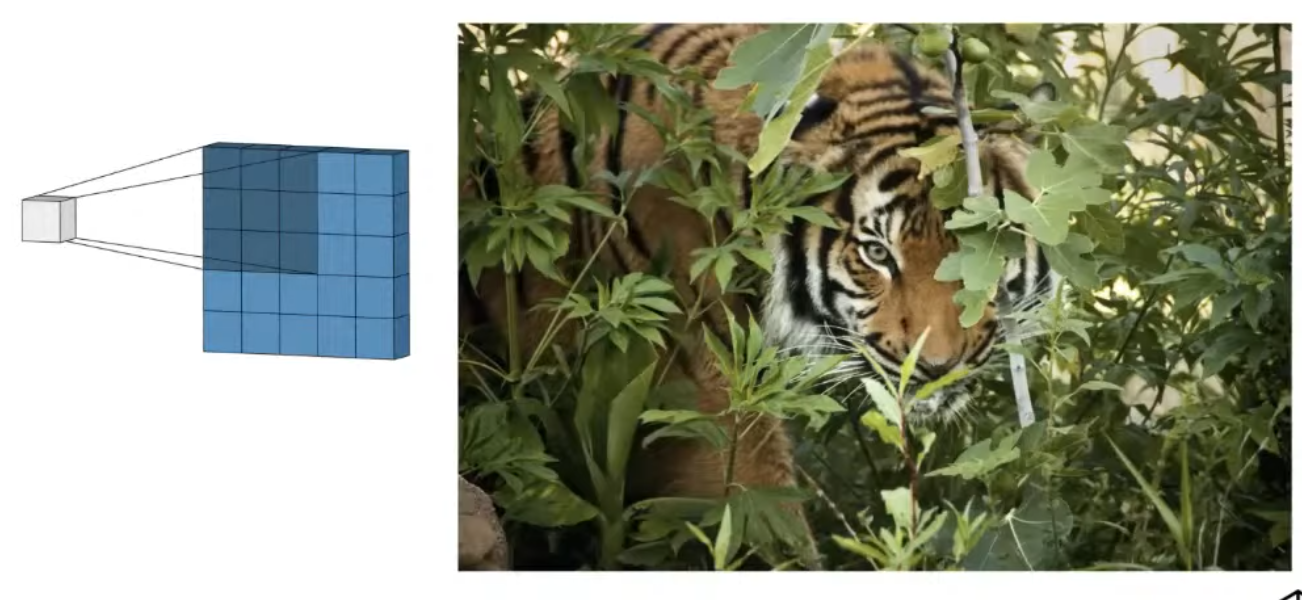

But inductive bias of CNNs let them to better generalize on small data, when unbiased models will need much more data to achieve comparable results.

# Vision Transformer (ViT)

Main idea: 

- split image into fixed-size patches (9, 16 or more patches)
- linearly embed patches and add 1D position embeddings (2D postion embeddings don't work better)
- in order to perform classification add an extra learnable “classification token” at the begining of the patch sequence
- pass this sequence through the Transformer encoder
- state of “classification token” ot the output of the Transformer encoder serves as the image representation
- use MLP head (two layers with GeLU activation) for classification 

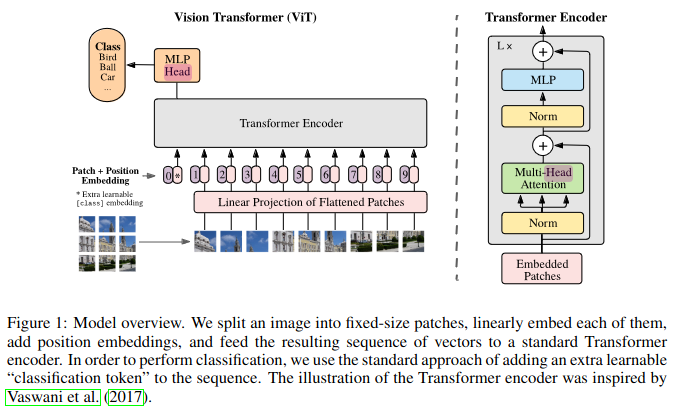

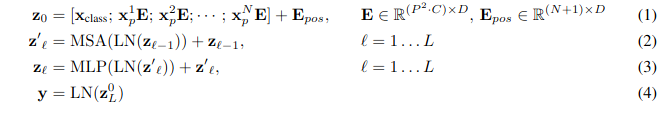


## ViT: variants

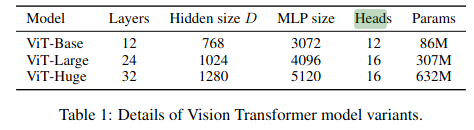

As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN.

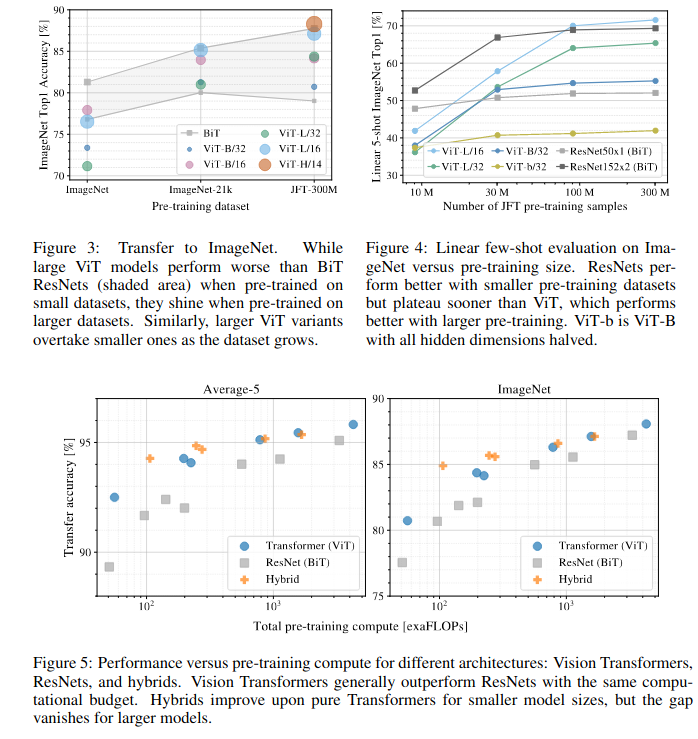

## ViT: results

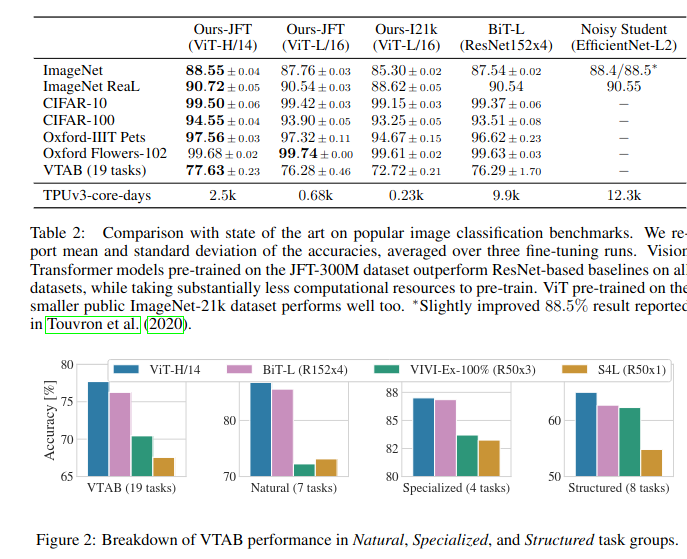

# ViT vs CNN:

Unlike CNN with local conv operations, attention heads of ViT usually look for a large distance, but some of them look locally.

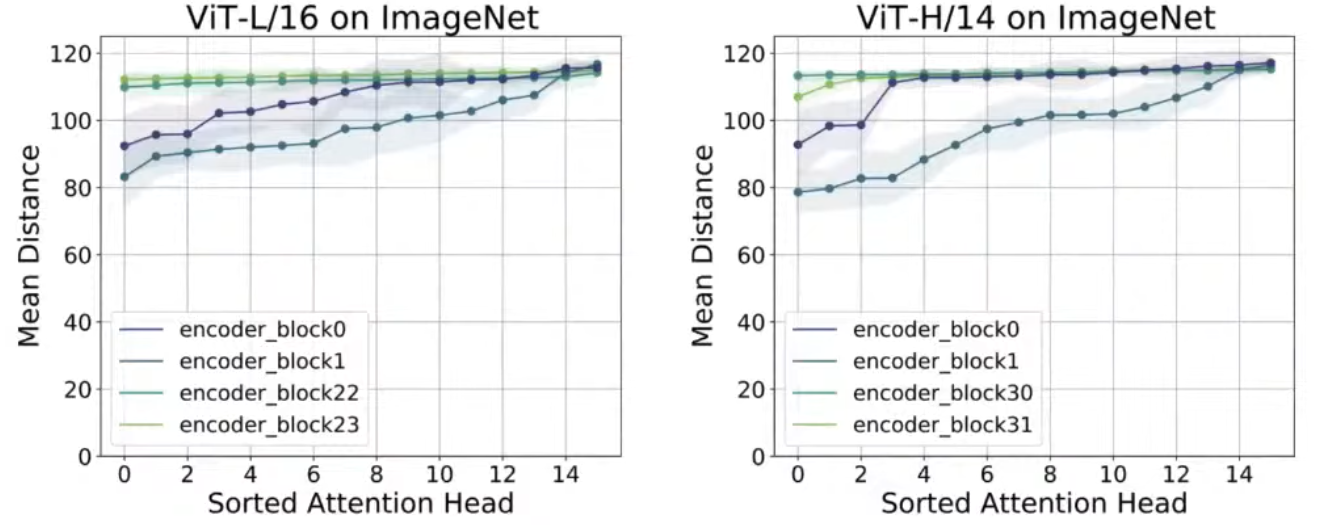

# Swin (Shifted windows) Transformer

Main idea: attention of classic ViT model has quadratic computation complexity, which will grow rapidly with the growth of image resolution + word tokens of classic transformers have fixed size while visual elements can vary substantially in scale. To handle this, Swin transformer builds hierarchical feature maps by starting from small-sized patches (outlined in gray on image below), and for each map computes self-attention only within some local patch (shown in red on image below) and gradually merges neighboring patches in deeper layers. The linear computational complexity is achieved by computing self-attention localy within non-overlapping windows that partition an image (outlined in red). The number of patches in each window is fixed, and thus the complexity becomes linear to image size.

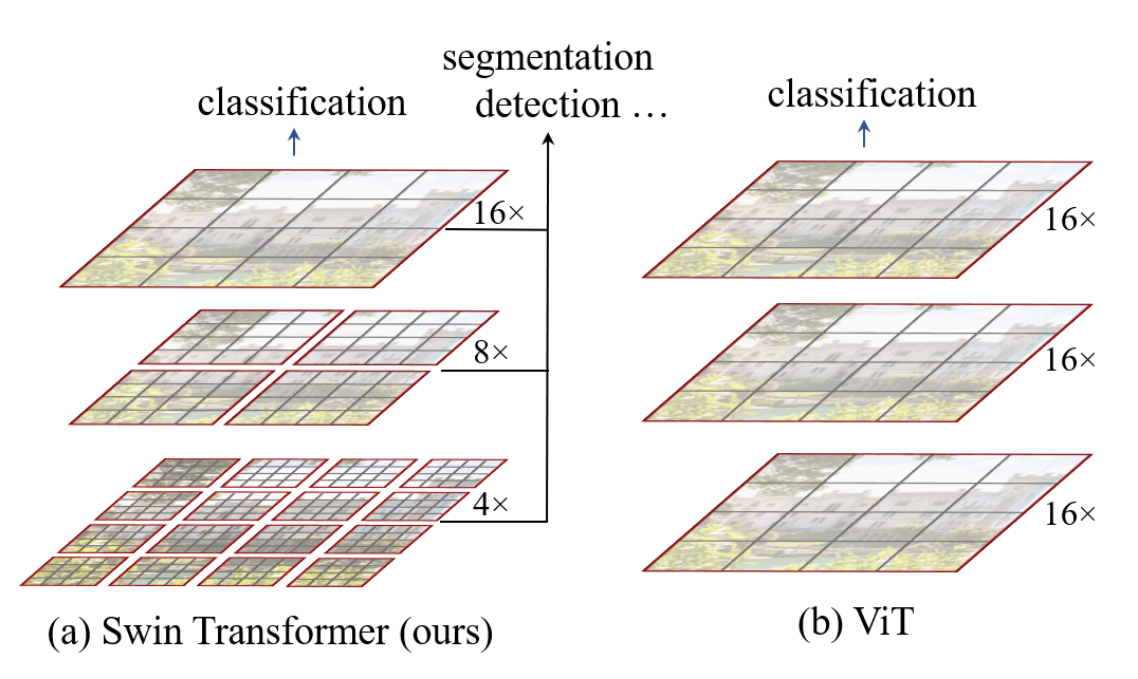

## Swin: shifted window

Second key element of Swin is its shift of the window partition between consecutive self-attention layers (shift is cyclic, i.e. window may
be composed of several sub-windows that are not adjacent in the feature map). Shifted windows connect windows from preceeding layer, and thus they provide information exchange between them.

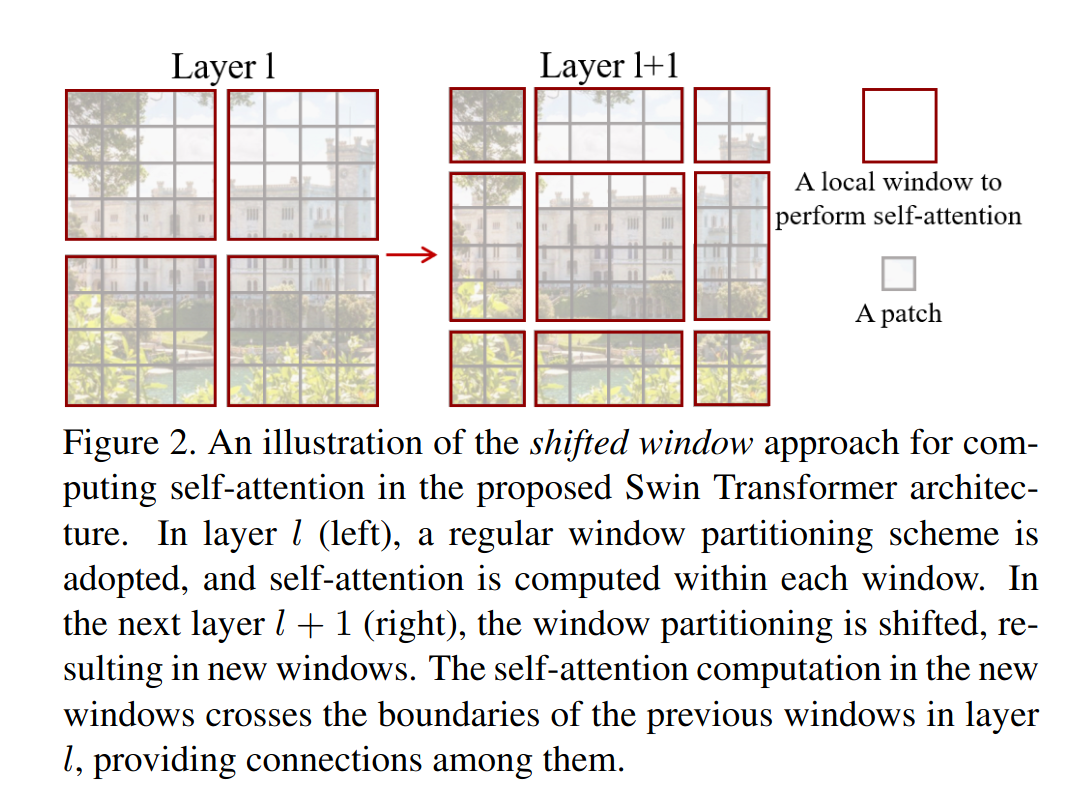

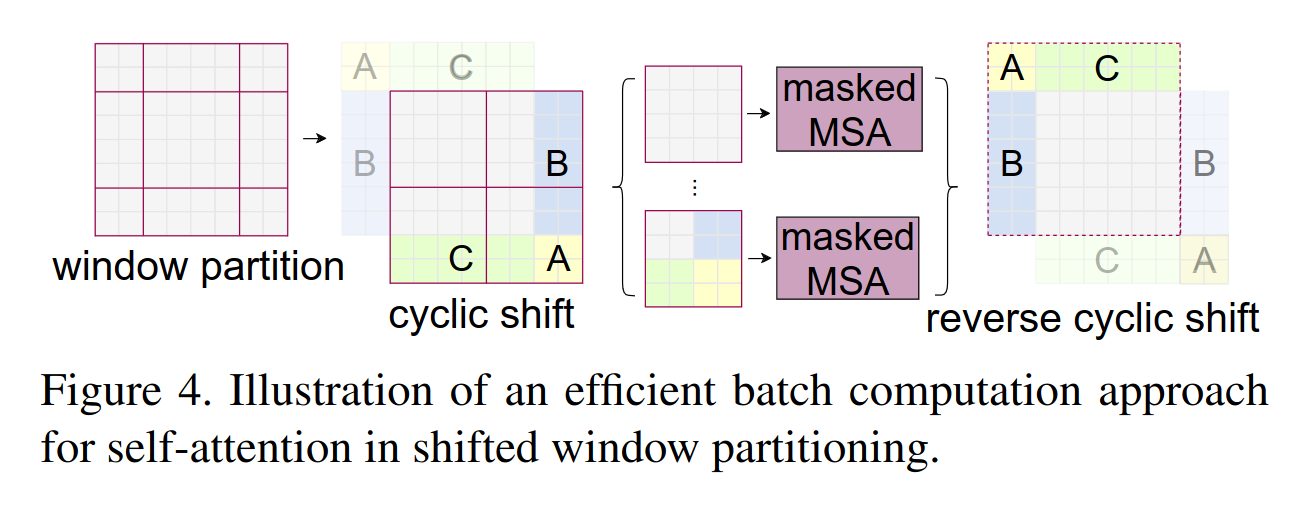

## Swin: architechture

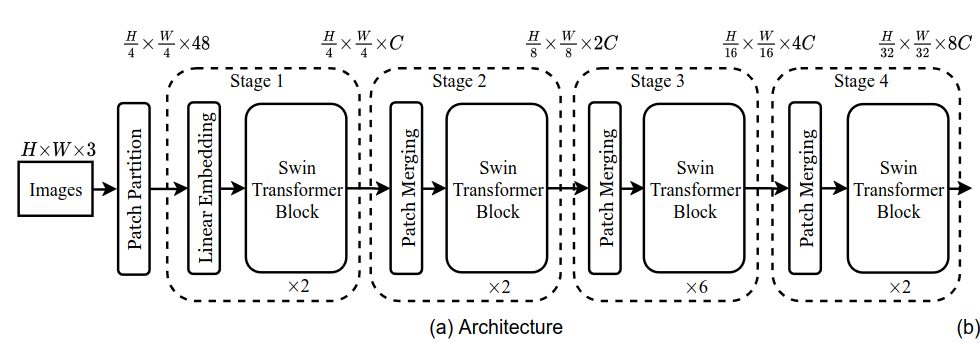

### Stage 1

At first Swin splits an input RGB image into non-overlapping patches by a patch splitting module, like ViT. Each patch is treated as a “token” and its feature is set as a concatenation of the raw pixel RGB values. In this implementation a patch size of 4 × 4 is used and thus the feature dimension of each patch is 4 × 4 × 3 = 48. Several Transformer blocks with modified self-attention computation (Swin Transformer blocks) are applied on these patch tokens. The Transformer blocks maintain the number of tokens (H/4 × W/4).

### Stage 2, 3, 4

To produce a hierarchical representation, the number of tokens is reduced by patch merging layers as the network gets deeper. The first patch merging layer concatenates the features of each group of 2 × 2 neighboring patches, and applies a linear layer on the 4C-dimensional concatenated features. This reduces the number of tokens by a multiple of 2 × 2 = 4 (2× downsampling of resolution), and the output dimension is set to 2C. Swin Transformer blocks are applied afterwards for feature transformation, with the res-olution kept at H/8 × W/8.

The procedure is repeated twice, as “Stage 3” and “Stage 4”, with output resolutions of H/16 × W/16 and H/32 × W/32, respectively.

### Swin Transformer block

Swin Transformer is built by replacing the standard multi-head self attention (MSA) module in a Transformer block by a module based on shifted windows with other layers kept the same. Swin Transformer block consists of a shifted window based MSA module, followed by a 2-layer MLP with GELU non-linearity in between. A LayerNorm (LN) layer is applied before each MSA module and each MLP, and a residual connection is applied after each module.

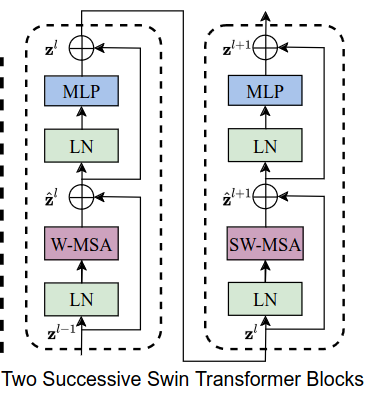

### Relative position bias

In computing self-attention a relative position bias B ∈ R <sup>M<sup>2</sup></sup> × <sup>M<sup>2</sup></sup> to each head in computing similarity:

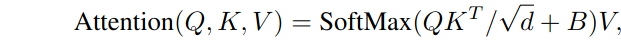

where Q, K, V ∈ RM 2×d are the query, key and value matrices; d is the query/key dimension, and M<sup>2</sup> is the number
of patches in a window. Since the relative position along each axis lies in the range [−M+1, M−1], a smaller-sized bias matrix ˆB ∈ R<sup>(2M<sup>2</sup> - 1) x (2M<sup>2</sup> - 1)</sup> is used, and values in B are taken from ˆB.

## Swin: results

### Classification

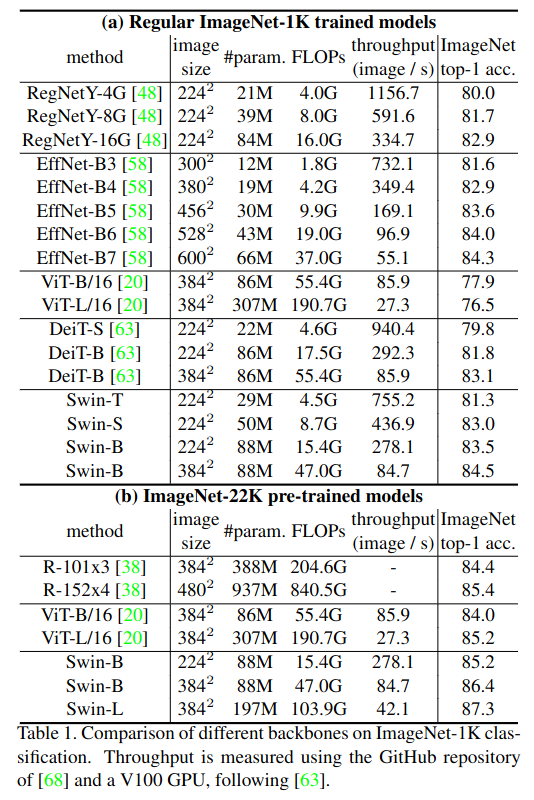

### Instance segmentation and detection

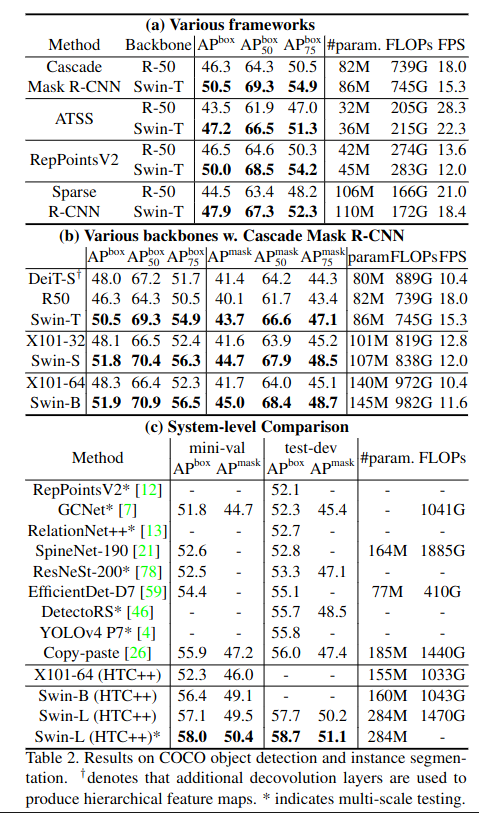

# SwinV2

Main idea: evolution of Swin architechture, main purpose is efficient scaling of Swin architechure

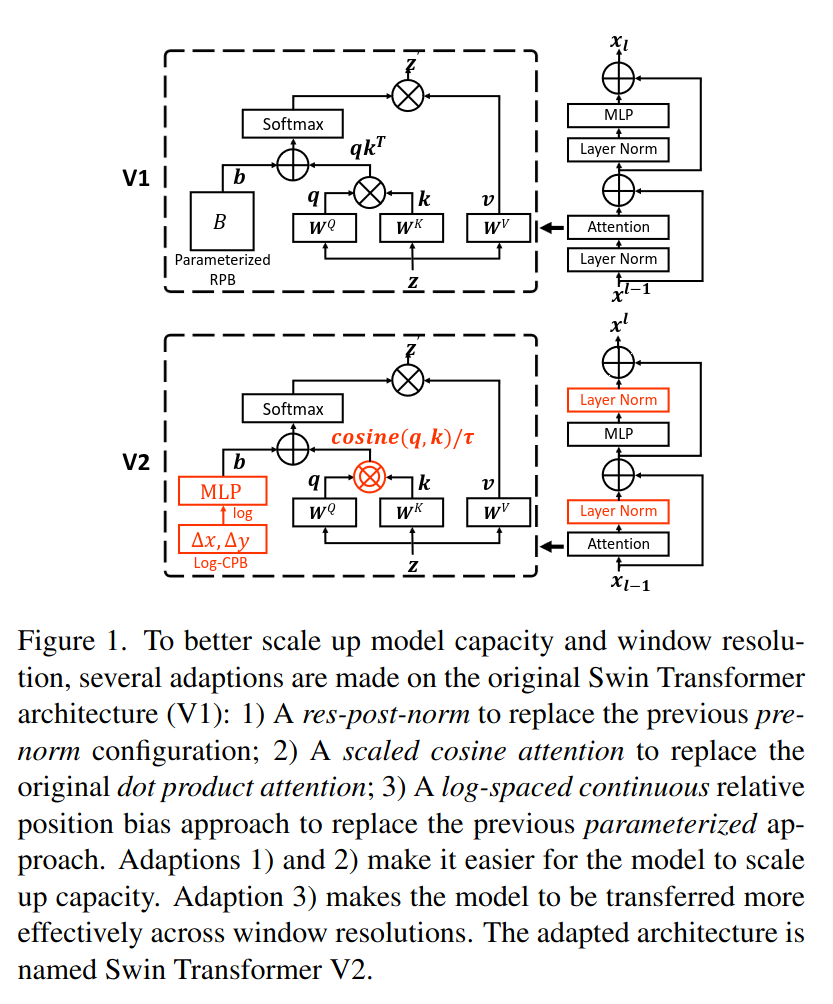

## Main changes

- residual post normalization: the output of each residual block is normalized **before** merging back into the main branch, and the amplitude of the main branch does not accumulate when the layer goes deeper. In vanilla Swin a layer norm layer was at the beginning of each block which lead to the fact that output activation values of each residual block were merged directly back to the main branch, and the amplitude of the main branch grows larger and larger at deeper layer. Large amplitude discrepancy in different layers causes training instability.

- scaled cosine attention: when use a dot product in large visual models, the learnt attention maps of some blocks and heads are
frequently dominated by a few pixel pairs, to ease this issue a scaled cosine attention approach is used; it computes the attention logit of a pixel pair i and j by a scaled cosine function:

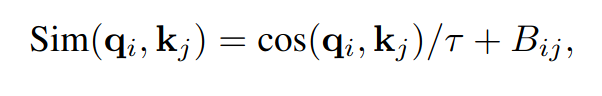

Where B<sub>i,j</sub> is relative position bias between pixel i and j, τ is a learnable scalar, non-shared across heads and layers, τ > 0.01. The cosine function is naturally normalized, and thus can have milder attention values.

- continuous relative position bias: instead of directly optimizing the parameterized biases, the continuous position bias approach adopts a small meta network on the relative coordinates:

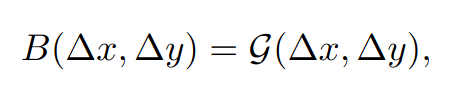

where G is a small network, e.g., a 2-layer MLP with a ReLU activation in between by default. The meta network G generates bias values for arbitrary relative coordinates, and thus can be naturally transferred to fine-tuning tasks with arbitrarily varying window sizes.

- log-spaced coordinates: when transferring across largely varying window sizes, a large portion of the relative coordinate range needs to be extrapolated. To ease this issue, log-spaced coordinates are used instead of the original linear-spaced ones:

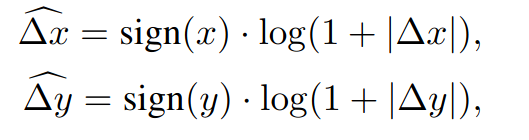

By using the log-spaced coordinates, when the relative position biases are transferred across window resolutions, the required extrapolation ratio will be much smaller than that of using the original linear-spaced coordinates.

# CoAtNet

Main idea: combine depthwise convolution (look CNN chapter) and relative attention module to get advantages from both CNNs and Transformers:

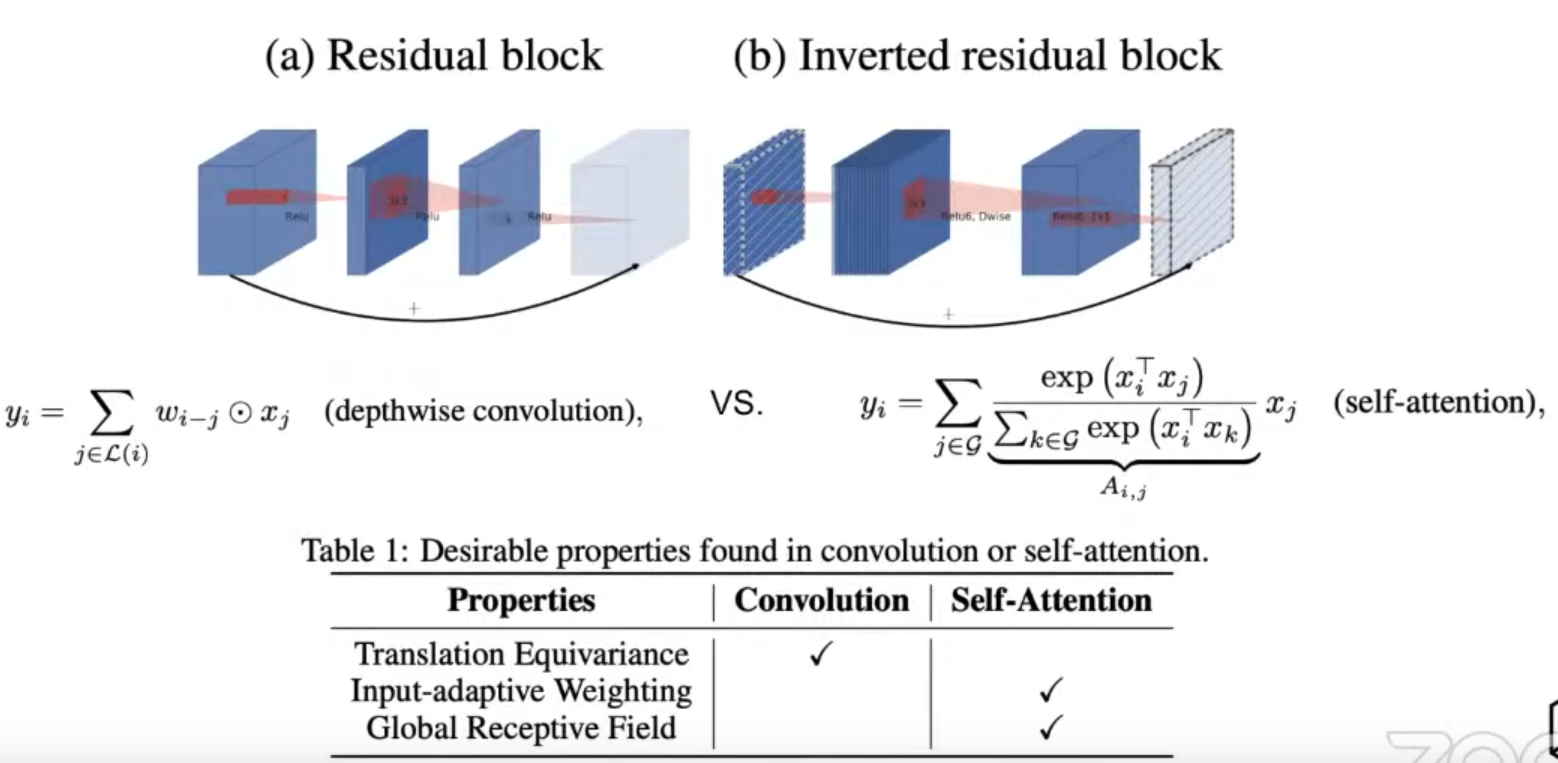

Atteniton blocks has large receptive field and thus help to find relations between different spatial positions of image while Conv blocks have translation equivalence, which improves generalization under datasets of limited size and prevent overfitting.

Combination formula:

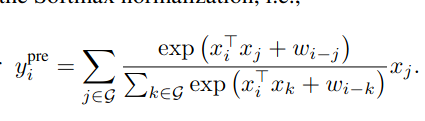

I.e. depthwise convolution is added before attention layer.

## CoAtNet: relative attention

Relative attention calculates attention score between every position of i and j of image. In this model it's input independent, i.e. doesn't depend on input pixels, and at inference time this only needs to be computed once and cached for future use.

## CoAtNet: architechture

Attention blocks are very computationally heavy, so they are added only on the deepest layers, which are spatially smaller than the first layers. On the first layers only conv and depthwise conv blocks are used.

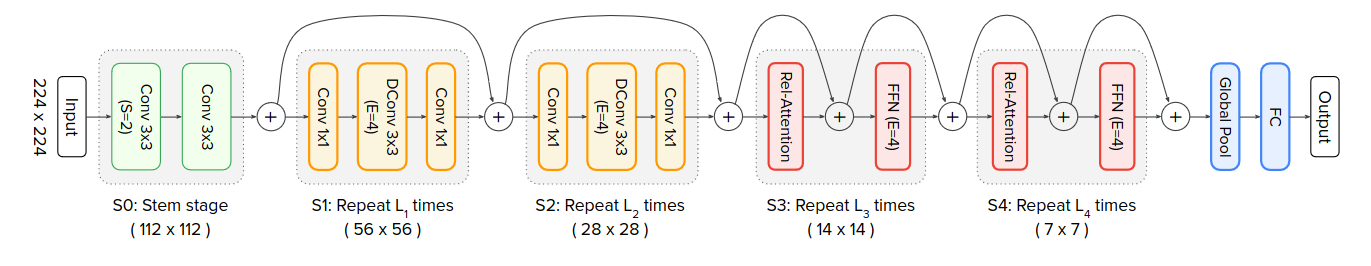

## CoAtNet: results

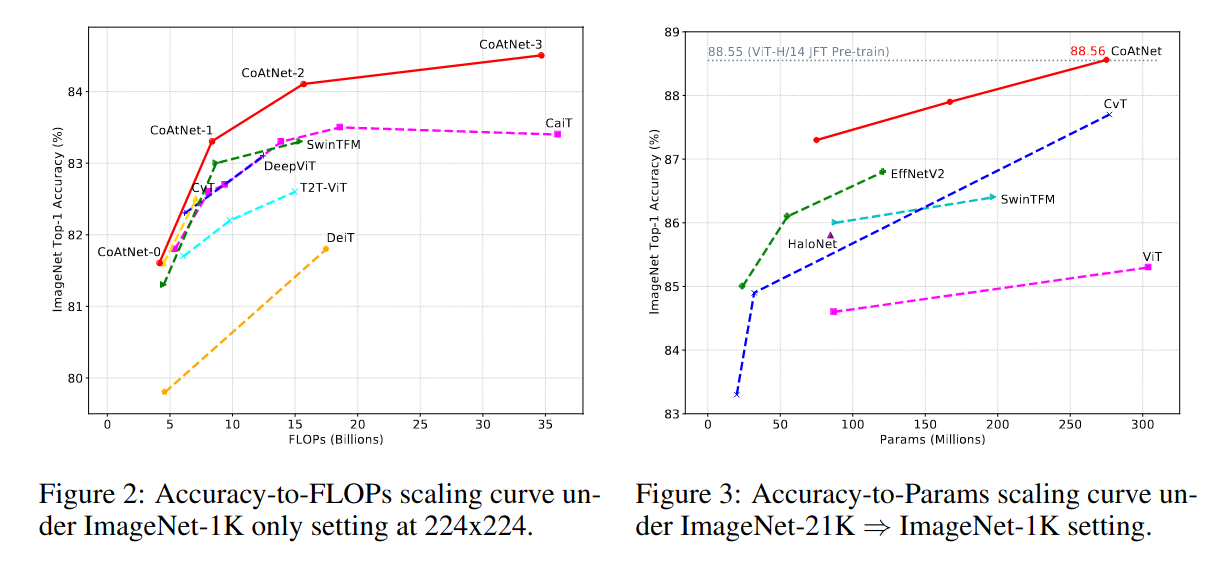

# Contrastive Language-Image Pre-Training (CLIP)

Main idea: neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

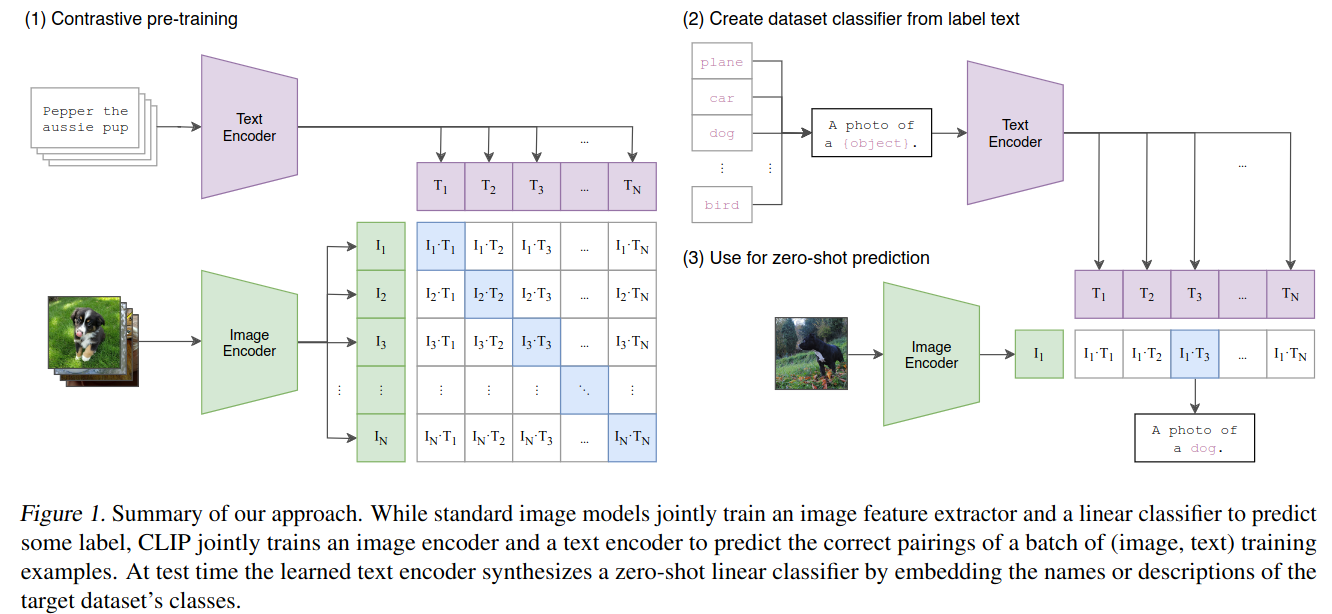

## CLIP: dataset

Dataset of 400 million (image, text) pairs collected form a variety of publicly available sources on the Internet. To attempt to cover as broad a set of visual concepts as possible, (image, text) pairs were searched as part of the construction process whose text includes one of a set of 500,000 queries (the base query list is all words occurring at least 100 times in the English version of Wikipedia, this is augmented with bi-grams). Then dataset was class balanced by including up to 20,000 (image, text) pairs per query.

## CLIP: models

Image encoder: ResNet-50 + replace global average pooling layer with an attention pooling mechanism.

Text encoder: Transformer (63M-parameter 12- layer 512-wide model with 8 attention heads), operates on a lower-cased byte pair encoding (BPE) representation of the text with a 49,152 vocab size.


## CLIP: train

The task is: predict which text (as a whole) is paired with which image and not the exact words of that text, this trick speeds up training process to 4x (comparing to prediction of consistency between image and each word in the text).

Given a batch of N (image, text) pairs, CLIP is trained to predict which of the N × N possible (image, text) pairings across a batch actually occurred. To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the cosine similarity of the image and text embeddings of the N real pairs in the batch while minimizing the cosine similarity of the embeddings of the N 2 − N incorrect pairings. Loss is symmetric cross entropy over these similarity scores (CE between each text sample and all images in batch + CE between each image and all texts in batch).

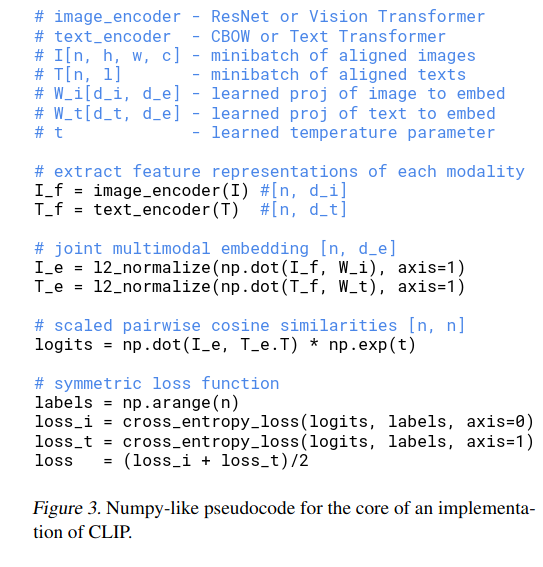

## CLIP: result

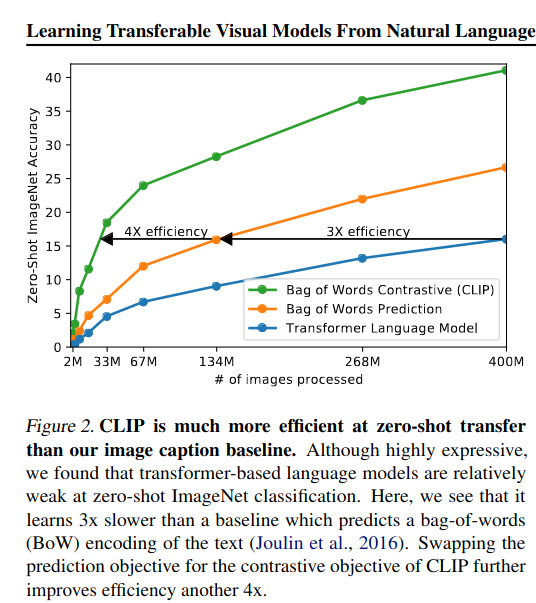

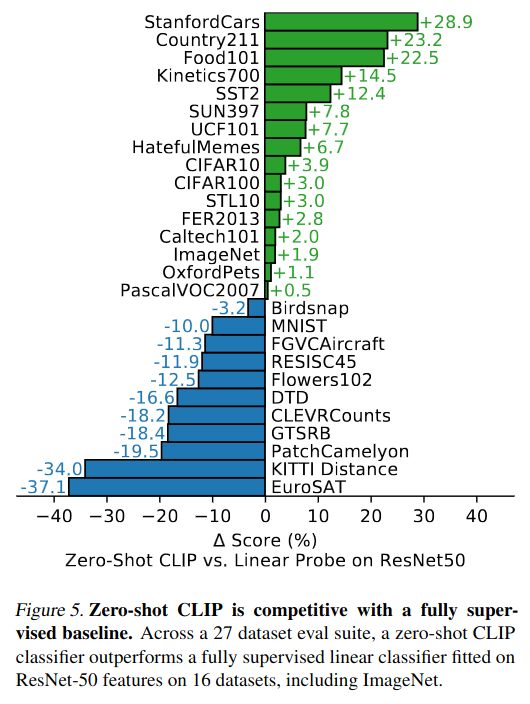

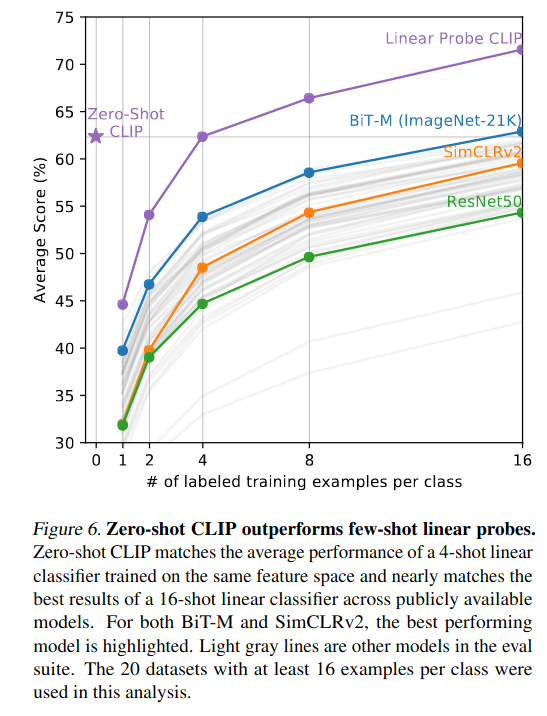

# A Large-scale ImaGe and Noisy-text embedding (ALIGN)

Main idea: train model with dual-encoder architechture (EfficientNet + BERT) on a Large-Scale Noisy Image-Text Dataset (1.8B image-text pairs). Some text-based filtering was done, but it wasn't intense. 

Summary of the method:

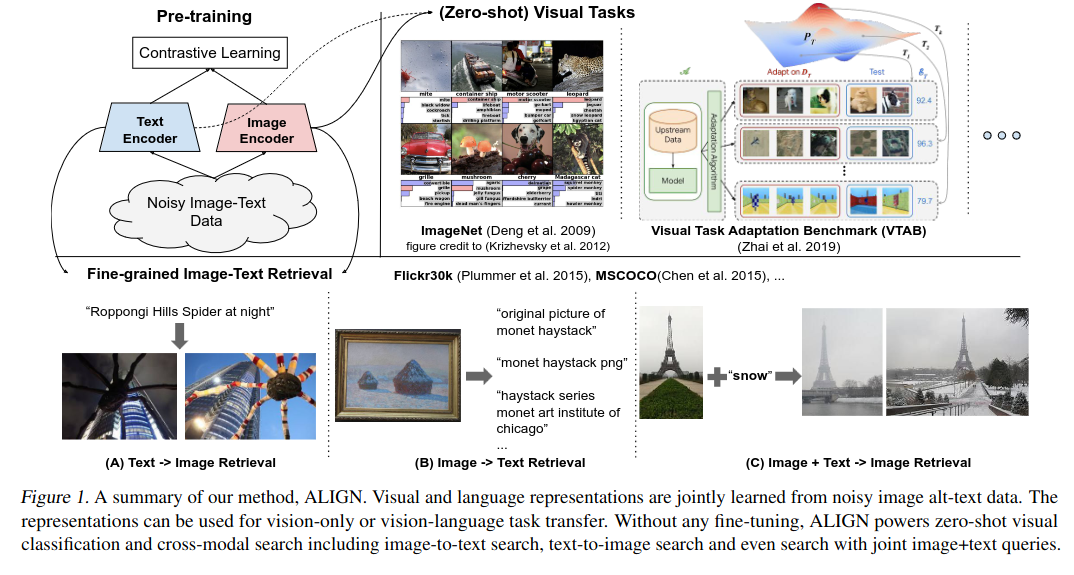

Example of dataset samples:

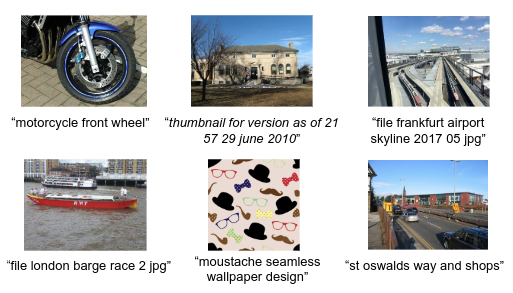

Sum of two losses was minimized: one for image-to-text classification 

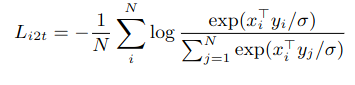

and the other for for text-to-image classification

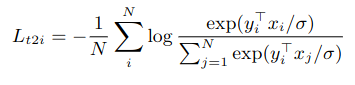

Here, x<sub>i</sub> and y<sub>j</sub>  are the normalized embedding of image in the i-th pair and that of text in the j-th pair, respectively. N is the batch size, and σ is the temperature to scale the logits.

## ALIGN: result

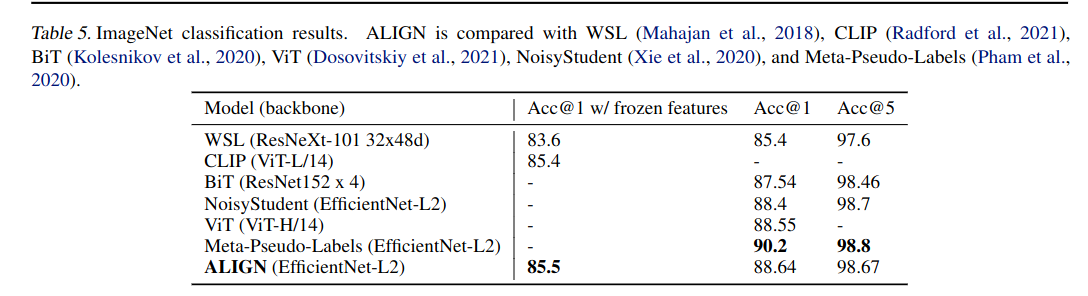

# BASIC-L

https://arxiv.org/pdf/2111.10050.pdf


# Lion

https://arxiv.org/pdf/2302.06675v4.pdf